In [3]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoModelForMaskedLM

from utils import *
from dataset import *
from preprocess import *
from wrapper import *
from models import *
from pipeline import PipelineGED

np.random.seed(1024)

# device = torch.device("cpu")
device = torch.device("cuda:0")
ntf()

In [2]:
np.random.seed(2027)

train_df = pd.read_csv('../data-org/train.csv', sep='\t', index_col='id').iloc[np.random.choice(range(45000), size=1000)]
test_df = pd.read_csv('../data-org/test.csv', sep='\t', index_col='id')

model_name = 'hfl/chinese-macbert-base'
ner_model_name = 'uer/roberta-base-finetuned-cluener2020-chinese'

test_dataset_config = {
    'model_name':model_name,
    # 'aux_model_name':ner_model_name,
    'maxlength':128,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':True, 
    'cut_all':False, 
}

test = DatasetWithAuxiliaryEmbeddings(df=test_df.reset_index(), **test_dataset_config)
test.tokenize()
test.construct_dataset()

train_dataset_config = {
    'model_name':model_name,
    # 'aux_model_name':ner_model_name,
    'maxlength':128,
    'train_val_split':-1,
    'test':False, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':True, 
    'cut_all':False, 
}

train = DatasetWithAuxiliaryEmbeddings(df=train_df.reset_index(), **train_dataset_config)
train.tokenize()
train.construct_dataset()

ntf()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\holaj\AppData\Local\Temp\jieba.cache
Loading model cost 0.699 seconds.
Prefix dict has been built successfully.
d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()
d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


In [4]:
checkpoints = [
    '../finetuned_models/ner_run_aug_74866/fold0/checkpoint-12195/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold1/checkpoint-12195/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold2/checkpoint-12195/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold3/checkpoint-8130/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold4/checkpoint-4065/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold5/checkpoint-8130/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold6/checkpoint-12195/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold7/checkpoint-8130/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold8/checkpoint-8130/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold9/checkpoint-12195/pytorch_model.bin'
]

data_configs = {
    'model_name':model_name,
    'maxlength':128,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'split_words':False, 
    'cut_all':False, 
}
clf = PipelineGED(model_name=model_name, data_configs=data_configs)

def apply_ged_pipeline(texts):
    probs, seq_probs, err_char_lst = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True, display=False)
    return probs, seq_probs, err_char_lst

Some weights of the model checkpoint at hfl/chinese-macbert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Eval on train set

In [5]:
probs, seq_probs, err_char_lst = apply_ged_pipeline(train_df.text.values)

prediction = probs.argmax(1)

data = train_df[['label', 'text']]
data['prediction'] = prediction
data['score'] = probs[:, 1]
data['confidence'] = 1 - 2*np.abs(data.score.values - data.prediction)
data = data[['label', 'prediction', 'score', 'confidence', 'text']]
data['err_chars'] = err_char_lst
print(len(data[data.label != data.prediction]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
    pd.options.display.max_colwidth = 100
    # display(data[data.label != data.prediction].sort_values(by='score'))
    display(data[data.label != data.prediction])
# data[data.label != data.prediction].to_csv('../case_analysis/aug.csv')
ntf()

d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


53


,label,prediction,score,confidence,text,err_chars
id,,,,,,
39214,1,0,0.146052,0.707895,云南大三女生康辰晨凭着三大优势--心理素质好、动作形体好、自身条件好，最终被确定为广州亚运会火种采集仪式的采火使者。,[]
34272,1,0,0.010333,0.979334,一位家长发文称，孩子遭到同班同学的欺凌，被同学用垃圾筐扣头，之后出现了失眠、恐惧等症状，经诊断为“急性应激反应”。,[]
15465,1,0,0.115681,0.768637,主体课堂教学模式是这所学校教学改革的重要组成部分，因为它不仅关乎学校素质教育的整体设计，而且关乎课堂教学的效率。,[]
33264,0,1,0.918064,0.836128,宇航服是世界上最昂贵的服装，虽然“神舟”七号宇航服的具体造价还不清楚，但目前世界上最贵宇航服的造价是150多万美元。。,"[虽, 然, 七, 的, 还, 清, 楚, ，, 但, 目, 的, 是, 5, 万, 美, 元, 。, 。]"
9278,1,0,0.467900,0.064199,科学，包括讲道理的科学，改变了人类的生存面貌，进而改变了西方人的生存面貌。至于这种改变是福是祸，则笔者不敢专断。,[]
27214,1,0,0.210036,0.579929,正如博斯克的西班牙尝试放弃托雷斯，弃用戈麦斯的德国勒夫，穆里尼奥的切尔西一度也让许尔勒顶在锋线上，斯科拉里也可尝试全新的无锋踢法。,[]
1998,1,0,0.118847,0.762306,2015年10月，屠呦呦因发现青篙素﹣﹣一种治疗疟疾的药物，在全球特别是发展中国家挽救了数百万人的生命，而获得诺贝尔生理学和医学奖。,[]
14813,1,0,0.021778,0.956445,我们一贯主张，国与国之间的争端应通过谈判解决，反对诉诸于武力或以武力相威胁的做法。,[]
13081,1,0,0.023196,0.953608,总体说来，山寨文化的泛滥与其说是对草根创新精神的彰显和标榜，不如说是对国人知识产权严重缺乏的揭露和讽刺。,[]


In [11]:
fp = ((data.label == 0).values * (data.prediction==1).values).sum()
fn = ((data.label == 1).values * (data.prediction==0).values).sum()
tp = ((data.label == 1).values * (data.prediction==1).values).sum()
tn = ((data.label == 0).values * (data.prediction==0).values).sum()

print(fp, fn, tp, tn)

precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2*precision*recall / (precision+recall)

print(precision, recall, f1)

8 43 688 261
0.9885057471264368 0.9411764705882353 0.9642606867554309


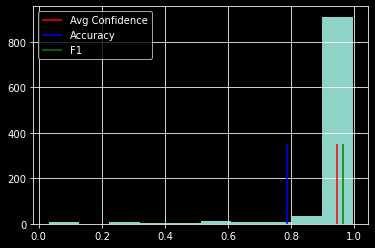

In [6]:
import matplotlib.pyplot as plt
data.confidence.hist()
plt.vlines(x=data.confidence.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=(tp+tn)/(tp+tn+fp+tn), ymin=0, ymax=350, colors='blue', label='Accuracy')
plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

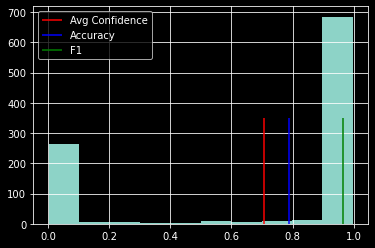

In [7]:

data['score'].hist()
plt.vlines(x=data.score.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=(tp+tn)/(tp+tn+fp+tn), ymin=0, ymax=350, colors='blue', label='Accuracy')
plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

### Eval on Test Set

In [27]:
probs, seq_probs, err_char_lst = apply_ged_pipeline(test_df.text.values)

prediction = probs.argmax(1)

data = test_df.copy(deep=True)
data['comp'] = pd.read_csv('../submissions/submission-v3-0.75624.csv', delimiter='\t').set_index('id').label
data['prediction'] = probs.argmax(1)
data['score'] = probs[:, 1]
data['confidence'] = 1 - 2*np.abs(data.score.values - data.prediction)

data = data[['comp', 'prediction',  'score', 'confidence', 'text']]
data['error_chars'] = err_char_lst
print(len(data[data.comp != data.prediction]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data[data.comp != data.prediction].sort_values(by='confidence'))
ntf()

d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


169


,comp,prediction,score,confidence,text,error_chars
id,,,,,,
1032,1,0,0.494821,0.010358,小江有时候觉得他自己挺聪明的，但是考试成绩总是不太好。,[]
53,1,0,0.487607,0.024787,每次路过街口的咖啡店，小徐总会停下脚步看下店里靠墙的角落。,[]
433,1,0,0.487458,0.025084,中国的教育政策不断变革，这要求每个学生重视各方面的均衡发展，加大了在体育和艺术方面的精力投入。,[]
404,0,1,0.512893,0.025786,夏季的池塘充满生机，鱼虾成群，水草随水流摆动，青蛙和知了你一言我一语的，好不热闹。,[了]
98,1,0,0.480589,0.038822,花园里开满了鲜明的玫瑰，红得那么艳丽。,[]
299,1,0,0.475539,0.048922,光阴似箭，一转眼你都大学毕业了，记得，我看见你那年才六岁。,[]
298,1,0,0.471797,0.056406,这是一册值得一读的书，因为它可以催人进取，促人猛醒，引人深思。,[]
213,0,1,0.535584,0.071169,张强从小生活在爷爷奶奶身边，因而对父母有着浓厚的感情。,[因]
214,0,1,0.538628,0.077255,雨珠砸在玻璃上，发出噼噼啪啪的声响。,[响]


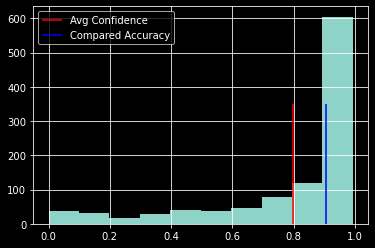

In [124]:
data.confidence.hist()
plt.vlines(x=data.confidence.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=len(data[data.comp == data.prediction]) / len(data), ymin=0, ymax=350, colors='blue', label='Compared Accuracy')
# plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

In [15]:
submissions = data[['prediction']].rename(columns={'prediction':'label'})
submissions['id'] = range(1, 1+len(submissions))
submissions = submissions[['id', 'label']]
submissions.to_csv('../submissions-aug/submission-da.csv', index=False, sep='\t')

# Loss

In [9]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch, focal_loss=True):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output['logits'], axis=-1)
        if focal_loss:
            loss = binary_focal_loss(output['logits'], batch["labels"].to(device), alpha=0.3, gamma=0.8, sum=False)
        else:
            loss = cross_entropy(output['logits'], batch["labels"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [5]:
# model = BertWithNER(bert_model=model_name, ner_model=ner_model_name)
model = AutoModelWithNER(model=model_name, ner_model=ner_model_name)
state_dict = torch.load(checkpoints[0], map_location=device)
# for key in list(state_dict.keys()):
#     state_dict[key.replace('bert', 'base_model')] = state_dict.pop(key)
model.load_state_dict(state_dict)
model.cuda()

Some weights of the model checkpoint at hfl/chinese-macbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at uer/roberta-base-finetuned-cluener2020-chinese were not used when initializi

AutoModelWithNER(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [10]:
train.dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'auxiliary_input_ids', 'labels'])
eval_outputs = train.dataset['val'].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/283 [00:00<?, ?ba/s]

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display()

,label,text
id,,
23495-1,1,海南“国际旅游岛”项目是我国由官方独立建造、独立规划、独立投资、独立管理、独立收支的特大型海...
39138,1,央视“成语大会”栏目将国学娱乐化，有利于更多人研究和了解国学。
20777,1,随着反腐力度的进一步加大，新的反腐形势也在出现，有的甚至更加隐秘。反腐是一场持久的战争，它的...
30283,1,“汕优63”杂交稻近几年的年种植面积都超过1亿亩，平均亩产稳定在约500千克左右，不仅产量高...
34053,1,通过这几年的努力，使中国的水面舰艇研制水平和研制能力已经进入世界先进行列，这为中国海军执行远...
41533,1,在此次重庆市青少年科技创新大赛中，同学们常围在一起相互鼓劲并认真总结得失，赢得的远远不只是比...
15549,1,价格改革涉及利益复杂，不仅要坚持改革的方向，积极推进，而且要对方案认真周密研究部署。
42976,1,南通老百姓和海内外游客在狼山不仅可以感受到江海神韵，还可以感受到民族文化的永恒魅力之所在。
11432,1,据美国务院发言人维多利亚·纽兰9日在例行新闻发布会上表示，希望中国发挥影响力，采取措施帮助阻...
